Number of GPUs available : 0
[]
Running with CPU
10
20
30
40
50
60
70
80
90
100
Execution time: 51.19805693626404


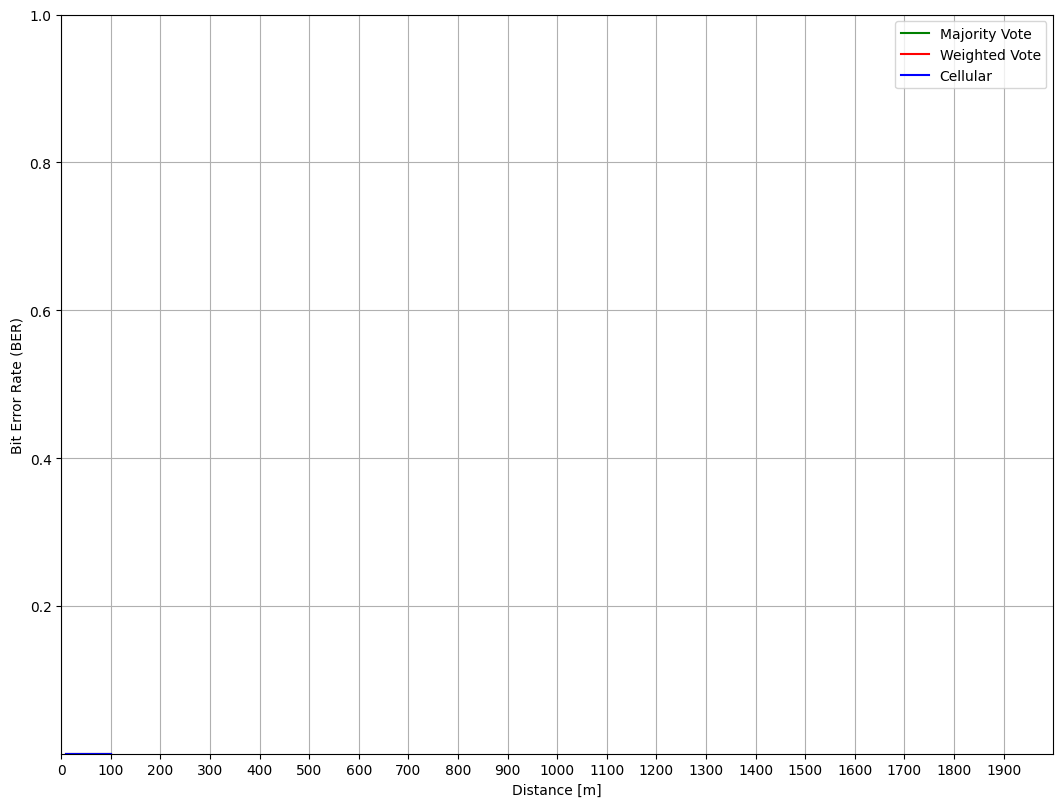

In [3]:
# -*- coding: utf-8 -*-
"""Rayleigh Experiment v2.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1Lj6h_Ms3gcbcA5jsXz6hMKP92o--Ubtl
"""

# Commented out IPython magic to ensure Python compatibility.
from scipy import constants
from scipy.spatial import distance
from scipy.signal import savgol_filter
import tensorflow as tf
import numpy as np
import time

gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
print(tf.config.list_physical_devices('GPU'))

test_gpu = False

if test_gpu == True:
    print("Running with GPU")
    if gpus:
        gpu_num = 0 # Number of the GPU to be used
        try:
            tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
            print('Only GPU number', gpu_num, 'used.')
            tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
        except RuntimeError as e:
            print(e)
if test_gpu == False:
        print("Running with CPU")

try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
# %matplotlib inline
import matplotlib.pyplot as plt

# For the implementation of the Keras models
from tensorflow.keras import Model

import multiprocessing

class Large_Scale_Fading():
  def __init__(self, num_ut, num_bs, num_ut_ant, num_bs_ant, reference_distance = 10, frequency = 3e9, path_loss_exponent = 2.7, test1 = False, show_plot = False, simple_Test = False):
    self.num_ut = num_ut
    self.num_bs = num_bs
    self.num_ut_ant = num_ut_ant
    self.num_bs_ant = num_bs_ant
    self.c = constants.speed_of_light
    self.d_0 = reference_distance
    self.f_0 = frequency 
    self.gamma = path_loss_exponent
    self.test_1 = test1
    self.show_plot = show_plot
    self.simple_test = simple_Test

  def calc_large_fading_coefficient(self, distance, db=False):
    if (distance > self.d_0):
      beta_db = (-20*np.log10(((4*constants.pi*self.d_0)/self.c)*self.f_0)) - (10*self.gamma*np.log10(distance/self.d_0))
    else: 
      beta_db = -20*np.log10(((4*constants.pi*distance)/self.c)*self.f_0)
    beta = np.power(10, beta_db/10)

    if db:
      return beta_db
    else:
      return beta

  def generate_array(self, distance_to_BS=0):
    # Code for generating random BS and UT.
    if self.test_1 == True:
      if self.num_bs == 3:
        bs = np.array([[-100, 0], [0, 0], [100, 0]])
      else:
        bs = np.array([[0, 0]])
      ut = np.array([[0, distance_to_BS]])
    else:
      bs = np.random.randint(low=-30, high=30, size=(self.num_bs, 2))
      ut = np.random.randint(low=-30, high=30, size=(self.num_ut, 2))

    #Generate Plot of BS and UTs
    if self.show_plot:
      for i in range(self.num_bs):
        plt.scatter(bs[i,0], bs[i,1])
        plt.annotate(f"BS-{i}", (bs[i,0], bs[i,1]))

      for i in range(self.num_ut):
        plt.scatter(ut[i,0], ut[i,1])
        ut_num = "UT_" + str(i)
        plt.annotate(ut_num, (ut[i,0], ut[i,1]))
      plt.title("Location of BS and UT(s)")
      plt.show()

    # Generate Array of distances between BS(s) and UT(s). Entry i, j is the distance between BS-i and UT-j. 
    self.distance_array = np.zeros([self.num_bs, self.num_ut])
    for i in range(self.num_bs):
      for j in range(self.num_ut):
        self.distance_array[i, j] = distance.euclidean(bs[i], ut[j])

    # Generate Array of path loss.
    self.path_loss_array = np.zeros([1, self.num_bs, self.num_bs_ant, self.num_ut, self.num_ut_ant, 1, 1], dtype=np.float64)
    for i in range(self.num_bs):
      for j in range(self.num_ut):
        self.path_loss_array[0, i, :, j, :, 0, 0] = self.calc_large_fading_coefficient(self.distance_array[i,j])
    self.path_loss_array = tf.complex(np.float32(self.path_loss_array), tf.zeros(1, dtype=tf.float32))

  def get_coefficients(self, ut_number):
    ind = np.argmin(self.distance_array, axis=0)
    return ind[ut_number]

  def __call__(self, h_freq, distance_to_BS=0):
    if self.simple_test == True:
      h_faded = h_freq*np.sqrt(distance_to_BS)

    else:
      # generate path loss array
      self.generate_array(distance_to_BS)

      # Broadcast shape of path loss array to shape of channel
      self.path_loss_array = tf.broadcast_to(self.path_loss_array, h_freq.shape)

      # Apply path loss
      h_faded = h_freq*np.sqrt(self.path_loss_array)

    return h_faded

class Data_Aggregation():
  def __init__(self, num_ut, num_ut_ant, Large_Scale_Fading):
    self._num_ut = num_ut
    self._num_ut_ant = num_ut_ant
    self._large_scale_fading = Large_Scale_Fading

  def __call__(self, batch_size, b_hat, weighted=False):
    b_final = np.zeros(b_hat[0].shape)
    if weighted == False:
      for h in range(batch_size):
        for j in range(self._num_ut):
          for k in range(self._num_ut_ant):
            for i in range(tf.shape(b_final)[3]):
              ones = 0
              zeros = 0
              for z in b_hat:
                if z[h, j, k, i] == 1:
                  ones += 1
                else: 
                  zeros += 1
              if ones > zeros:
                b_final[h, j, k, i] = 1
              elif ones < zeros:
                b_final[h, j, k, i] = 0
              else:
                # Equal amount of 1s and 0s. Even amout of BS.
                # Get which BS has lowest distance to the UT
                x = self._large_scale_fading.get_coefficients(j)
                b_final[h, j, k, i] = b_hat[x][h, j, k, i]

    if weighted == True:
      total_distance = np.sum(self._large_scale_fading.distance_array, axis=0)
      for h in range(batch_size):
        for j in range(self._num_ut):
          for k in range(self._num_ut_ant):
            for i in range(tf.shape(b_final)[3]):
              value = 0
              for z in range(len(b_hat)):
                if b_hat[z][h, j, k, i] == 0:
                  value += (np.log10(total_distance[j])-np.log10(self._large_scale_fading.distance_array[z, j]))/np.log10(total_distance[j])*(-1)
                else:
                  value += (np.log10(total_distance[j])-np.log10(self._large_scale_fading.distance_array[z, j]))/np.log10(total_distance[j])*(1)
              
              if value < 0:
                b_final[h, j, k, i] = 0
              else:
                b_final[h, j, k, i] = 1

    return b_final

class TestModel(Model):
  def __init__(self, num_ut, num_bs, num_ut_ant, num_bs_ant, perfect_csi, cell_free = False):
    super().__init__()

    self._num_bits_per_symbol = 2
    self.cell_free = cell_free
    # Set BS and UT stuff
    self._num_ut = num_ut
    self._num_bs = num_bs
    self._num_ut_ant = num_ut_ant
    self._num_bs_ant = num_bs_ant
    self._num_streams_per_tx = self._num_ut_ant
    self._perfect_csi = perfect_csi

    # Setup Stream Management
    if self.cell_free:
      self._rx_tx_association = np.zeros([1, self._num_ut])
      self._rx_tx_association[0, :] = 1
      self._stream_management = sn.mimo.StreamManagement(self._rx_tx_association, self._num_streams_per_tx)
    else:
      self._rx_tx_association = np.zeros([self._num_bs, self._num_ut])
      self._rx_tx_association[0, :] = 1
      self._stream_management = sn.mimo.StreamManagement(self._rx_tx_association, self._num_streams_per_tx)

    # Setup OFDM Resource Grid
    self._rg = sn.ofdm.ResourceGrid(num_ofdm_symbols=14,
                                      fft_size=76,
                                      subcarrier_spacing=30e3,
                                      num_tx=self._num_ut,
                                      num_streams_per_tx=self._num_streams_per_tx,
                                      cyclic_prefix_length=6,
                                      pilot_pattern="kronecker",
                                      pilot_ofdm_symbol_indices=[2,11])

    self._n = int(self._rg.num_data_symbols*self._num_bits_per_symbol)
    
    # Instantiate modules
    self._binary_source = sn.utils.BinarySource()
    self._mapper = sn.mapping.Mapper("qam", self._num_bits_per_symbol)
    self._rg_mapper = sn.ofdm.ResourceGridMapper(self._rg)
    self._large_scale_fading = Large_Scale_Fading(self._num_ut, self._num_bs, self._num_ut_ant, self._num_bs_ant, test1=True, show_plot = False, simple_Test = False)
    self._rayleigh_fading = sn.channel.RayleighBlockFading(self._num_bs, self._num_bs_ant, self._num_ut, self._num_ut_ant)
    self._generate_channel = sn.channel.GenerateOFDMChannel(self._rayleigh_fading, self._rg, normalize_channel=True)
    self._apply_channel = sn.channel.ApplyOFDMChannel(add_awgn=True)
    self._ls_est = sn.ofdm.LSChannelEstimator(self._rg, interpolation_type="nn")
    self._remove_nulled_subcarriers = sn.ofdm.RemoveNulledSubcarriers(self._rg)
    self._lmmse_equ = sn.ofdm.LMMSEEqualizer(self._rg, self._stream_management)
    self._demapper = sn.mapping.Demapper("app", "qam", self._num_bits_per_symbol, hard_out="True")
    self._data_aggregation = Data_Aggregation(self._num_ut, self._num_ut_ant, self._large_scale_fading)

  def call(self, batch_size, beta = 1, weighted=False):
    #no = sn.utils.ebnodb2no(ebno_db=30, num_bits_per_symbol=self._num_bits_per_symbol, coderate=1, resource_grid=self._rg)
    
    no_db = -110
    no = tf.constant([np.power(10, no_db/10)], dtype=tf.float32)

    bits = self._binary_source([batch_size, self._num_ut, self._rg.num_streams_per_tx, self._n])
    x = self._mapper(bits)
    x_rg = self._rg_mapper(x)
    
    # Generate Channel
    h_freq = self._generate_channel(batch_size)

    # Apply Large Scale Fading to channel
    h_freq_hat = self._large_scale_fading(h_freq, distance_to_BS = beta)

    # Apply Channel
    y = self._apply_channel((x_rg, h_freq_hat, no))

    # Use perfect CSI or Channel Estimator
    if self._perfect_csi:
        h_hat = self._remove_nulled_subcarriers(h_freq)
        err_var = 0.0
    else:
        h_hat, err_var = self._ls_est ([y, no])
    
    if self.cell_free:
      # Split channel tensor into num_bs tensors
      h_hat = tf.split(h_hat, num_or_size_splits=self._num_bs, axis=1)

      # Split received symbols tensor into num_bs tensors
      y = tf.split(y, num_or_size_splits=self._num_bs, axis=1)

      # Apply LMMSE Equalizer for each BS
      b_hat = []
      for i, j in zip(y, h_hat):
        x_hat, no_eff = self._lmmse_equ([i, j, err_var, no])
        b_hat.append(self._demapper([x_hat, no_eff]))
      
      # Do majority vote to find final bits
      b_final =  self._data_aggregation(batch_size, b_hat, weighted=weighted)
    
    else:
      x_hat, no_eff = self._lmmse_equ([y, h_hat, err_var, no])
      b_final = self._demapper([x_hat, no_eff])


    return bits, b_final

#ebno_db = 0
batch_size = 1

model = TestModel(num_ut=1, num_bs=3, num_ut_ant=1, num_bs_ant=64, perfect_csi = False, cell_free = True)
model2 = TestModel(num_ut=1, num_bs=1, num_ut_ant=1, num_bs_ant=64, perfect_csi = False, cell_free = False)
#model3 = TestModel(num_ut=1, num_bs=5, num_ut_ant=1, num_bs_ant=64, perfect_csi = False)
# ber = []
# x = []
# ber2 = []
# ber3 = []

# for i in range(3, 8):
#   for j in range(9, 0, -1):
#     b, b_hat = model(batch_size=batch_size, beta=j*10**-i, weighted=False)
#     ber.append(sn.utils.metrics.compute_ber(b, b_hat))
#     x.append(j*10**-i)
#     #b2, b_hat2 = model(batch_size=batch_size, beta=j*10**-i, weighted=True)
#     b3, b_hat3 = model2(batch_size=batch_size, beta=j*10**-i)
#     #ber2.append(sn.utils.metrics.compute_ber(b2, b_hat2))
#     ber3.append(sn.utils.metrics.compute_ber(b3, b_hat3))
  
# plt.rcParams["figure.figsize"] = (12.8, 9.6)
# plt.loglog(x, ber, "r", label="Majority")
# #plt.loglog(x, ber2, "b", label="Weighted")
# plt.loglog(x, ber3, "g", label="Cellular")
# plt.ylabel("Bit Error Rate (BER)")
# plt.xlabel("Path Loss")
# plt.gca().invert_xaxis()
# plt.legend()
# plt.show()


ber = []
x = []
ber2 = []
ber3 = []
tests = 1


start = time.time()
for distance_to_bs in range(10, 110, 10):
  print(distance_to_bs)
  x1 = 0
  x2 = 0
  x3 = 0
  for i in range(tests):
    b, b_hat = model(batch_size=batch_size, beta=distance_to_bs, weighted=False)
    x1 += sn.utils.metrics.compute_ber(b, b_hat)

    b, b_hat = model(batch_size=batch_size, beta=distance_to_bs, weighted=True)
    x2 += sn.utils.metrics.compute_ber(b, b_hat)
    
    b, b_hat = model2(batch_size=batch_size, beta=distance_to_bs)
    x3 += sn.utils.metrics.compute_ber(b, b_hat)

  ber.append(x1/tests)
  ber2.append(x2/tests)
  ber3.append(x3/tests)
  x.append(distance_to_bs)

print("Execution time:",time.time()-start)

window_size = 7
ber_hat = savgol_filter(ber, window_size, 3)
ber2_hat = savgol_filter(ber2, window_size, 3)
ber3_hat = savgol_filter(ber3, window_size, 3)

plt.rcParams["figure.figsize"] = (12.8, 9.6)
plt.plot(x, ber_hat, "g", label="Majority Vote")
plt.plot(x, ber2_hat, "r", label="Weighted Vote")
plt.plot(x, ber3_hat, "b", label="Cellular")

#plt.yscale("symlog", linthreshy=1e-7)
#ax.plot(x, ber, "g")
#ax.set_yscale("symlog")
# plt.semilogy(x, ber2_hat, "r", label="Weighted Vote")
# plt.semilogy(x, ber3_hat, "b", label="Cellular")
# ax.set_ylabel("Bit Error Rate (BER)")
# ax.set_xlabel("Distance [m]")
#ax.set_ylim(([0, 5e-1]))
#plt.xticks(np.arange(min(x), max(x)+1, 100))
# ax.set_ylim([1e-3, 1e0])
# ax.set_yticks([1e-3, 1e-2, 1e-1])
# ax.grid()
# ax.legend()
plt.ylabel("Bit Error Rate (BER)")
plt.xlabel("Distance [m]")
plt.ylim([1e-6, 1e0])
plt.xlim([0, 2000])
plt.xticks(np.arange(0, 2000, 100))
plt.legend()
plt.grid()
# plt.show()